<a href="https://colab.research.google.com/github/BDouchet/Gan_flickr30k/blob/main/Embeddinglayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Glove Embedding**

The dataset is composed of >30k images of size 256x256 mostly representing human interaction. The image format is *.jpg*. A csv file compile the associated captions of the images.

## Useful Functions

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from os import listdir

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1BzL7oYRJm8wG0yAMamaUP-wZraD7Qjku'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('flickr30k_images.zip')

with ZipFile('flickr30k_images.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


Store the captions into a pandas file

In [2]:
df=pd.read_csv('/content/results.csv',sep='|')
df=df.rename(columns={' comment_number':'comment_number',' comment':'comment'})
print(df.columns)
df.loc[19999]['comment_number','comment']=[4,'A dog runs across the grass .']
df['comment_number']=pd.to_numeric(df['comment_number'])
df

Index(['image_name', 'comment_number', 'comment'], dtype='object')


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


To get all the filenames

In [3]:
filenames=df.image_name.unique()
filenames

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg', ...,
       '997876722.jpg', '99804383.jpg', '998845445.jpg'], dtype=object)

In [4]:
captions=df.set_index(['image_name','comment_number'])
captions

comment
image_name     comment_number                                                   
1000092795.jpg 0                Two young guys with shaggy hair look at their...
               1                Two young , White males are outside near many...
               2                Two men in green shirts are standing in a yard .
               3                    A man in a blue shirt standing in a garden .
               4                         Two friends enjoy time spent together .
...                                                                          ...
998845445.jpg  0                A man in shorts and a Hawaiian shirt leans ov...
               1                A young man hanging over the side of a boat ,...
               2                A man is leaning off of the side of a blue an...
               3                A man riding a small boat in a harbor , with ...
               4                A man on a moored blue and white boat with hi...

[158915 rows x 1 columns]

Read an image and its associated caption.

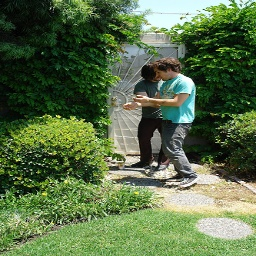

 A man in a blue shirt standing in a garden .


(256, 256, 3)

In [5]:
def read_image_caption(img,number):
    #read the image
    img_path = 'images/'+img
    im=cv2.imread(img_path)
    comment=captions.loc[img,number]['comment']
    return im, comment

img, text = read_image_caption('1000092795.jpg',3)
cv2_imshow(img)
print(text)
img.shape


## Glove



In [6]:
import nltk  
import random  
import string
import re
from os import listdir
nltk.download('stopwords')  
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


clean the caption : Take off stopwords and useless words

In [7]:
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
stop_words = set(stopwords.words('english'))

def clean_caption(caption):
  tokens = caption.split()  
  tokens = [re_punc.sub('',w) for w in tokens] # enleve les ' et les 
  tokens = [word for word in tokens if word.isalpha()] # enleve les nombres
  tokens = [word for word in tokens if word not in stop_words] # enleve les stopword
  tokens = [word for word in tokens if len(word) > 1] # on conserve les mots dont la taille est supérieur à 1
  return ' '.join(tokens)

In [8]:
print(captions['comment'][0])
print(clean_caption(captions['comment'][0]))

 Two young guys with shaggy hair look at their hands while hanging out in the yard .
Two young guys shaggy hair look hands hanging yard


The Tokenizer

In [9]:
maxlen=10
max_words=10000
texts=captions['comment'].to_numpy().copy()
for i,text in enumerate(texts):
    text=clean_caption(text)
    texts[i]=text
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=max_words,lower='True')
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)
print(sequences[0])

[3, 6, 270, 2018, 79, 144, 121, 269, 426]


In [22]:
import itertools


word_index=tokenizer.word_index
print(dict(itertools.islice(word_index.items(),100)))

{'man': 1, 'woman': 2, 'two': 3, 'people': 4, 'wearing': 5, 'young': 6, 'white': 7, 'shirt': 8, 'black': 9, 'blue': 10, 'red': 11, 'girl': 12, 'sitting': 13, 'men': 14, 'boy': 15, 'standing': 16, 'dog': 17, 'playing': 18, 'street': 19, 'group': 20, 'front': 21, 'walking': 22, 'holding': 23, 'one': 24, 'water': 25, 'three': 26, 'the': 27, 'women': 28, 'green': 29, 'child': 30, 'looking': 31, 'little': 32, 'an': 33, 'large': 34, 'outside': 35, 'yellow': 36, 'person': 37, 'children': 38, 'brown': 39, 'hat': 40, 'ball': 41, 'small': 42, 'next': 43, 'dressed': 44, 'another': 45, 'running': 46, 'building': 47, 'jacket': 48, 'riding': 49, 'around': 50, 'orange': 51, 'near': 52, 'field': 53, 'crowd': 54, 'stands': 55, 'beach': 56, 'background': 57, 'pink': 58, 'behind': 59, 'sidewalk': 60, 'jumping': 61, 'table': 62, 'girls': 63, 'sits': 64, 'grass': 65, 'snow': 66, 'bike': 67, 'looks': 68, 'top': 69, 'camera': 70, 'air': 71, 'asian': 72, 'dogs': 73, 'stand': 74, 'city': 75, 'wall': 76, 'playe

In [ ]:
data=tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen,truncating='post')
pd.DataFrame(data,index=texts)

,0,1,2,3,4,5,6,7,8,9
Two young guys shaggy hair look hands hanging yard,0,3,6,270,2018,79,144,121,269,426
Two young White males outside near many bushes,0,0,3,6,7,639,35,52,153,1340
Two men green shirts standing yard,0,0,0,0,3,14,29,203,16,426
man blue shirt standing garden,0,0,0,0,0,1,10,8,16,641
Two friends enjoy time spent together,0,0,0,0,3,421,738,528,9880,102
...,...,...,...,...,...,...,...,...,...,...
man shorts Hawaiian shirt leans rail pilot boat fog mountains background,1,88,2128,8,538,582,2196,137,2719,378
young man hanging side boat like fog rolling hill behind,6,1,269,111,137,289,2719,910,229,59
man leaning side blue white boat sits body water,0,1,308,111,10,7,137,64,245,25
man riding small boat harbor fog mountains background,0,0,1,49,42,137,2228,2719,378,57


Download Glove matrix

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1U_SEvo3fFteHG_jvfUmb_RGZB0C3RkOD'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Glove.6B.zip')

with ZipFile('Glove.6B.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
embeddings_index={}
f =open('glove.6B.100d.txt')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()

print('Found %s word vectors.'% len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim=100
embedding_matrix=np.zeros((10000,100))
found=0
words=[]
for word,i in word_index.items():
    if i< max_words:
        words.append(word)
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            found+=1
            embedding_matrix[i]=embedding_vector
print(str(found)+'/10000')


9722/10000


In [ ]:
print(embedding_matrix[1])

[ 3.72929990e-01  3.85030001e-01  7.10860014e-01 -6.59110010e-01
 -1.01280003e-03  9.27150011e-01  2.76149988e-01 -5.62030002e-02
 -2.42939994e-01  2.46319994e-01 -1.84489995e-01  3.13980013e-01
  4.89829987e-01  9.25600007e-02  3.29580009e-01  1.50560006e-01
  5.73170006e-01 -1.85289994e-01 -5.22769988e-01  4.61910009e-01
  9.20379996e-01  3.10009997e-02 -1.62459999e-01 -4.05669987e-01
  7.86210001e-01  5.77220023e-01 -5.35009980e-01 -6.82280004e-01
  1.69870004e-01  3.63099992e-01 -7.17730001e-02  4.72330004e-01
  2.78060008e-02 -1.49509996e-01  1.75430000e-01 -3.75730008e-01
 -7.85170019e-01  5.81709981e-01  8.68589997e-01  3.14450003e-02
 -4.58970010e-01 -4.09170017e-02  9.58970010e-01 -1.69750005e-01
  1.30449995e-01  2.74340004e-01 -6.94850013e-02  2.24019997e-02
  2.49770001e-01 -2.15360001e-01 -3.24059993e-01 -3.98669988e-01
  6.86129987e-01  1.79229999e+00 -3.78479987e-01 -2.24769998e+00
 -7.70250022e-01  4.65820014e-01  1.24109995e+00  5.77560008e-01
  4.11509991e-01  8.43280

In [ ]:
matrix=pd.DataFrame(data=embedding_matrix,index=['']+words)
matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
man,0.37293,0.38503,0.710860,-0.659110,-0.001013,0.92715,0.27615,-0.056203,-0.24294,0.246320,-0.18449,0.313980,0.48983,0.09256,0.329580,0.150560,0.57317,-0.185290,-0.522770,0.461910,0.92038,0.031001,-0.162460,-0.40567,0.786210,0.577220,-0.535010,-0.682280,0.169870,0.363100,-0.071773,0.47233,0.027806,-0.149510,0.175430,-0.375730,-0.785170,0.58171,0.86859,0.031445,...,0.411510,0.843280,-0.542590,-0.167150,0.739270,-0.093477,0.90278,0.508890,-0.50031,0.264510,0.154430,-0.294320,0.109060,-0.266670,0.354380,0.049079,0.18018,-0.585900,-0.555420,-0.289870,0.742780,0.345300,-0.028757,-0.226460,-1.311300,-0.571900,-0.523060,-0.126700,-0.098678,-0.534630,0.286070,-0.375010,0.45742,0.045975,-0.246750,0.045656,-0.38302,-0.937110,0.039138,-0.539110
woman,0.59368,0.44825,0.593200,0.074134,0.111410,1.27930,0.16656,0.240700,0.39045,0.327660,-0.75034,0.350070,0.76057,0.38067,0.175170,0.031791,0.46849,-0.216530,-0.462820,0.399670,0.16623,-0.011477,0.044059,0.30325,0.615300,0.470470,-0.440360,-1.596300,0.184330,0.231930,0.204520,0.51617,0.657340,-0.345200,0.234460,-0.620040,-0.687410,0.28575,1.06050,0.469160,...,0.440950,0.725880,-0.092053,-0.022406,0.720390,0.107600,0.84116,0.303120,-0.42544,0.056362,0.131090,-0.071181,-0.105790,0.566770,0.545470,0.841130,0.14861,-0.626280,-0.683910,-1.083100,-0.088385,0.321670,0.477940,0.091868,-1.255900,-1.226800,0.085401,0.368330,0.081566,-0.766110,0.877510,-0.220080,0.82401,-0.092207,-0.459410,0.465710,-0.56018,-0.546480,0.151620,-0.307540
two,-0.20154,0.32739,0.000476,-0.224520,0.441100,0.33599,0.40657,0.665270,-0.63852,0.044351,0.59747,-0.086113,0.39787,0.88041,0.170050,-0.142750,-0.17920,-0.116220,-0.561750,0.213780,0.95272,-0.276540,0.225670,0.45870,0.832970,-0.904890,-0.240190,-0.416690,-0.318420,0.335990,0.175160,0.24785,-0.360020,-0.118950,0.412390,0.195490,0.071716,0.31329,-0.36803,0.515460,...,-0.686150,1.149100,0.361290,0.501560,0.339090,0.143700,0.41324,0.751410,0.00799,-0.017592,-0.586090,-0.095992,0.128280,-0.604890,0.272010,0.384970,-0.28595,-0.508070,-1.153900,-0.065888,1.128500,0.284620,-0.247820,0.448590,-1.472600,-0.126820,0.180530,-0.047814,0.016943,-0.225430,-0.227570,0.293410,-0.86753,-0.015261,-1.267500,0.020593,-0.72345,0.023054,0.540160,-0.080331
people,0.29019,0.80497,0.311870,-0.327060,-0.472370,1.13630,-0.37966,0.115690,0.41912,0.016284,-0.06543,-0.004047,0.77688,-0.24936,0.188170,-0.640080,-0.02027,-0.185280,-1.065100,0.691150,1.04720,0.361710,0.808630,-0.42767,-0.182990,-0.278470,0.438390,-0.023336,0.373590,-0.358800,0.472610,0.73946,0.015123,0.059862,-0.066841,-0.388420,0.223610,0.80570,0.33789,-0.052222,...,-0.352080,1.489300,-0.217010,-0.246150,0.551850,0.972240,0.58526,-0.029754,0.57944,-0.647980,-0.123710,-0.534590,-0.205280,-0.535990,0.308950,0.539350,0.11853,0.427490,-1.087200,-0.234090,0.738820,0.157490,-0.566420,0.162350,-1.911700,-0.019262,-0.502930,-0.175840,-0.538810,-0.393970,0.813300,-0.316540,0.25971,-0.482020,-1.445200,0.274190,-0.72652,-0.336030,0.459980,-0.112780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
matrix.to_csv('embedding_matrix.csv')